In [1]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

import os
import pybullet as p
import pybullet_data
import math
import numpy as np
import random

from gym_myrobot.envs.robot_reach import ReachEnv
# robenv = ReachEnv(reward_type='dense', 
#                   use_fixed_target=True, 
#                   usegui=True, 
#                   usegripper=True,
#                   fixed_target=[0.1, 0.1, 0.1])  # reward type = 'sparse' 时，为稀疏奖励，可以配合her算法使用

robenv = ReachEnv(reward_type='dense', 
                  
                  usegui=True, 
                  target_range=0.10
                 
                  )  # reward type = 'sparse' 时，为稀疏奖励，可以配合her算法使用

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import numpy as np
import gym
import os

device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')

/home/pp/anaconda3/envs/baseline/lib/python3.6/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [1]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

import os
import pybullet as p
import pybullet_data
import math
import numpy as np
import random
from gym_myrobot.envs.robot_reach import ReachEnv
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import numpy as np
import gym
import os

device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')

In [2]:
for i in range(2000):
    robenv.reset()

In [2]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [3]:
class Actor(nn.Module):
    '''给出一个分布的均值'''
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_dim, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, action_dim)
        
    def forward(self, state):
        x = torch.tanh(self.linear1(state))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x 

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_dim, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
    
    def forward(self, state):
        x = torch.tanh(self.linear1(state))
        x = torch.tanh(self.linear2(x))
        x = self.linear3(x)
        return x

In [5]:
class ActorCritic(nn.Module):
    '''把Actor和Critic封装到一起了，这样可以直接评估，比较简单'''
    def __init__(self, state_dim, action_dim, action_std_init):
        super(ActorCritic, self).__init__()
        
        self.action_dim = action_dim
        self.action_var = torch.full((self.action_dim,), action_std_init**2).to(device) # 把一个标量变成动作维度的向量
        
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        
    def set_action_std(self, new_action_std):
        self.action_var = torch.full((self.action_dim,), new_action_std**2).to(device)
        
    def act(self, state):
        '''输入单个状态，得到动作和log, 是之后要用到选择动作的子函数'''
        action_mean = self.actor(state)           # 一行均值，列数是动作维度，1维向量
        cov_mat = torch.diag(self.action_var)     # 一行方差，可以直接diag
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()  # [x,x,x], x
    
    def evaluate(self, state, action):
        '''输入一批状态和动作，得到一批评估结果, .log_prob(action)中action不必是这个dist筛出来的'''
        action_mean = self.actor(state)          # 好多行均值，列数是动作维度，2维矩阵
        action_var = self.action_var.expand_as(action_mean)  # 方差也要变成好多行
        cov_mat = torch.diag_embed(action_var)   # 不能直接diag，要用diag_embed
        dist = MultivariateNormal(action_mean, cov_mat)
        
        # 如果动作的dim是1，则需要给他改变一下形状，
        # 因为多维action[batch_size, action_dim]，而单维的action[batch_size]，少了个维度,要变成[bactch_size,1]
        if self.action_dim == 1:
            action = action.reshape(-1, 1)   # [batch_size, 1] 只有第二个维度有，下面的log_prob才好使
        
        action_logprobs = dist.log_prob(action)
        state_values = self.critic(state)
        dist_entropy = dist.entropy()
        
        return action_logprobs, state_values, dist_entropy 

In [6]:
class PPO:
    def __init__(self, env, lr_actor, lr_critic, gamma, K_epochs, eps_clip, actions_std_init=0.6):
        self.env = env
        self.state_dim = 6
        self.action_dim = env.action_space.shape[0]
        self.max_action = float(env.action_space.high[0])
        
        self.action_std = actions_std_init
        self.gamma = gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        self.actions_std_init = actions_std_init
        self.buffer = RolloutBuffer()
        
        # 初始化Actor_Critic 整体网络
        self.policy = ActorCritic(self.state_dim, self.action_dim, self.action_std).to(device)
        self.policy_old = ActorCritic(self.state_dim, self.action_dim, self.action_std).to(device)
        
        # 初始化优化器和损失函数
        # 因为一个policy里面有两个网络，所以优化器的参数和学习率是两个字典组成的列表
        self.optimizer = torch.optim.Adam([
            {'params':self.policy.actor.parameters(), 'lr':lr_actor},
            {'params':self.policy.critic.parameters(), 'lr':lr_critic}
        ])

        self.loss_fn = nn.MSELoss()
        self.summary = {}
    
    def set_action_std(self, new_action_std):
        '''给ActorCritic类设置一下std'''
        self.policy.set_action_std(new_action_std)
        self.policy_old.set_action_std(new_action_std)
 
    def decay_action_std(self, action_std_decay_rate, min_action_std):
        '''随着步数增大， 减小action的方差, 并给两个actor网络设置方差'''
        self.action_std -= action_std_decay_rate
        self.action_std = round(self.action_std, 4)      # 保留四位小数
        if (self.action_std <= min_action_std):
            self.action_std = min_action_std
        self.set_action_std(self.action_std)
    
    def select_action(self, state):
        '''根据状态获取动作，得到的动作是用于与环境交互的， 不用于update'''
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_log_prob = self.policy_old.act(state)
        
        # 选择动作的同时，把state， action, action_log_prob 加入buffer,都是tensor
        self.buffer.states.append(state)
        self.buffer.actions.append(action)    
        self.buffer.logprobs.append(action_log_prob)
        
        return self.max_action * action.detach().cpu().numpy()
    
    def test_select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action = self.policy_old.actor(state)
            return self.max_action * action.detach().cpu().numpy()
         
    def update(self):
        # 先把reward转换为能用的折扣过的rewards
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)  # 把折扣过的动作重头排列
        # 归一化reward
        rewards = torch.FloatTensor(rewards).to(device)
        rewards = (rewards - rewards.mean())/(rewards.std() + 1e-7)  # [4000]
        
        # buffer里面的这三个东西本来就是tensor，所以纵向连接dim=0也要用tensor的连接方法
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)   # [4000, 11]
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device) # [4000, 3]
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device) # [4000]
        
        # update
        for _ in range(self.K_epochs):
            
            # 用现在的actor和critic，评估旧的states和actions
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
        #   [4000],   [4000, 1]     [4000]
            
            # 把state_values 变成[batch_size] 和rewards形状一致
            state_values = torch.squeeze(state_values)
            
            # 计算ratio
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # 计算loss
            advantages = rewards - state_values.detach()
            surr1 = ratios *  advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            
            # PPO 的最终loss
            loss = -torch.min(surr1, surr2) - 0.01 * dist_entropy + 0.5 * self.loss_fn(state_values, rewards) #[4000]
            loss = loss.mean()
            self.summary['loss'] = loss.item()
            
            # 梯度更新
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        # 更新目标网络，用load模型参数的方法来硬更新模型
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # 清空buffer
        self.buffer.clear()        
        
    
    def save(self, checkpoint_path):
        '''只保存模型参数'''
        torch.save(self.policy_old.state_dict(), checkpoint_path)
        
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path))
        self.policy.load_state_dict(torch.load(checkpoint_path))

In [7]:
max_ep_len = 1000                # 每个回合最大步数
max_train_timesteps = int(3e6)
action_std = 0.6
action_std_decay_rate = 0.05
min_action_std = 0.1
action_std_decay_freq = int(2.5e5)  # 多少步减小一下std
print_freq = max_ep_len * 10        # 多少步打印一下奖励
save_model_freq = int(1e5)          # 多少步保存一下模型

update_timestep = max_ep_len*4  # buffer存4000组数据训练一次
K_epochs = 80                   # update一次更新网络80次

eps_clip = 0.2
gamma = 0.99
lr_actor = 0.0003
lr_critic = 0.001

env = robenv

ppo_agent = PPO(env, lr_actor, lr_critic, gamma, K_epochs, eps_clip, action_std)

directory = 'PPO_weigths' + '/' + 'arm' + '/'
if not os.path.exists(directory):
      os.makedirs(directory)
checkpoint_path = directory + 'ppo_{}_dgx.pth'.format('arm')  # 模型保存会覆盖这个文件，整套训练下来，就保存一个文件
# checkpoint_path = directory + 'ppo_{}.pth'.format('arm')  # 模型保存会覆盖这个文件，整套训练下来，就保存一个文件

# 测试

In [8]:
import rospy

## 仿真环境

In [9]:
envsim = robenv

In [10]:

ppo_agent_new = PPO(envsim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, action_std)

In [11]:
ppo_agent_new.load(checkpoint_path)


In [12]:
for j in range(1):
    states_sim = []
    state = envsim.reset()
    state = state['observation']
    for i in range(500):
        action = ppo_agent_new.test_select_action(state)
        state, reward, done, info = envsim.step(action)
        rospy.sleep(0.02)
        print(info)
        print(reward)
        state = state['observation']
        states_sim.append(state)
        if done:
            break

/home/pp/deeplearning/open_manipulator_X_RL/gym_myrobot/envs/robot_env.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  jointPoses_now = np.array(jointPoses_now)[:, 0]


{'is_success': 0.0}
-0.23430431846947164
{'is_success': 0.0}
-0.2329837489841483
{'is_success': 0.0}
-0.23165930970470686
{'is_success': 0.0}
-0.2303310817705265
{'is_success': 0.0}
-0.2289989620175592
{'is_success': 0.0}
-0.22766317771287786
{'is_success': 0.0}
-0.2263236193332582
{'is_success': 0.0}
-0.22498028232660774
{'is_success': 0.0}
-0.22363338507260236
{'is_success': 0.0}
-0.22228282906563976
{'is_success': 0.0}
-0.22092857647622652
{'is_success': 0.0}
-0.21957086876995374
{'is_success': 0.0}
-0.21820965595708136
{'is_success': 0.0}
-0.21684482402166522
{'is_success': 0.0}
-0.21547653494223762
{'is_success': 0.0}
-0.21410497094241562
{'is_success': 0.0}
-0.2127299175979958
{'is_success': 0.0}
-0.21135158278705238
{'is_success': 0.0}
-0.20997002202447718
{'is_success': 0.0}
-0.2085851451799568
{'is_success': 0.0}
-0.20719704569413464
{'is_success': 0.0}
-0.20580585789150802
{'is_success': 0.0}
-0.204411566516716
{'is_success': 0.0}
-0.20301415012819093
{'is_success': 0.0}
-0.2

In [13]:
import matplotlib.pyplot as plt

In [14]:
states_sim = np.array(states_sim)
states_sim.shape

(500, 6)

In [15]:
states_sim_pose = states_sim[:, :3]

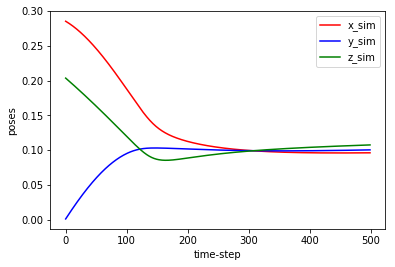

In [16]:
t = np.arange(0, 500, 1)
plt.plot(t, states_sim_pose[:,0],'r', t,states_sim_pose[:,1],'b', t, states_sim_pose[:,2],'g')
plt.xlabel('time-step')
plt.ylabel('poses')
plt.legend(['x_sim','y_sim','z_sim'], loc='best')

## 真实环境 

In [2]:
from gym_myrobot.envs.real_arm_env import RealarmEnv
envreal = RealarmEnv(reward_type='dense',use_gripper=True)

/home/pp/anaconda3/envs/baseline/lib/python3.6/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
envreal.operate_gripper(0.01)

In [6]:
envreal.reset()


{'observation': array([0.28900871, 0.        , 0.1911777 , 0.        , 0.05215535,
        0.        ]),
 'achieved_goal': array([0.28900871, 0.        , 0.1911777 ]),
 'desired_goal': array([0.16267134, 0.099657  , 0.33989573])}

In [19]:
for j in range(1):
    states_real = []
    state = envreal.reset()
    state = state['observation']
    for i in range(500):
        action = ppo_agent_new.test_select_action(state)
        state, reward, done, info = envreal.step(action)
        print(info)
        state = state['observation']
        states_real.append(state)
        if done:
            break

{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}
{'is_success': 0.0}


In [ ]:
states_real = np.array(states_real)
states_real_pose = states_real[:, :3]

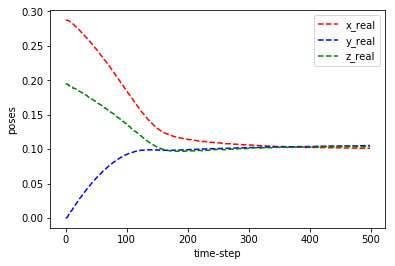

In [ ]:
t = np.arange(0, 500, 1)
plt.plot(t, states_real_pose[:,0],'r--', t,states_real_pose[:,1],'b--', t, states_real_pose[:,2],'g--')
plt.xlabel('time-step')
plt.ylabel('poses')
plt.legend(['x_real','y_real','z_real'], loc='best')

# 单点跟踪仿真和实物对比

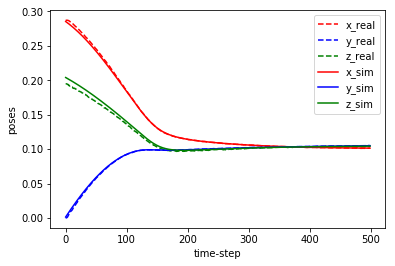

In [ ]:
t = np.arange(0, 500, 1)
plt.plot(t, states_real_pose[:,0],'r--', t,states_real_pose[:,1],'b--', t, states_real_pose[:,2],'g--', t, states_sim_pose[:,0],'r', t,states_sim_pose[:,1],'b', t, states_sim_pose[:,2],'g')
plt.xlabel('time-step')
plt.ylabel('poses')
plt.legend(['x_real','y_real','z_real','x_sim', 'y_sim', 'z_sim'], loc='best')